In [25]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import statsmodels.api as sm
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from xgboost import XGBClassifier





# **Data Preprocessing & Preparation**

## **Data Cleaning**

In [2]:
df = pd.read_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# 2111 rows, 17 columns
df.shape

(2111, 17)

In [5]:
#2111 rows, 17 columns with no missing data!
#8 numerical columns - Age, Height, Weight, FCVC, NCP, CH20, FAF, TUE
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [6]:
#Check for null values
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [7]:
#max age is 61, min 14
df.describe()

#(Farayola, 2025)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [8]:
#Checking duplications & removing first occurance
duplicates = df.duplicated()

num_duplicates =  duplicates.sum()

print("Number of duplicated rows:", num_duplicates)
df = df.drop_duplicates(keep='first')
df.shape

Number of duplicated rows: 24


(2087, 17)

## **Data Integration**

In [9]:
#Data Integration - Ensuring column names are consistent
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


<ipython-input-10-4efc5749e5dc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='nobeyesdad', data=df, palette='viridis')


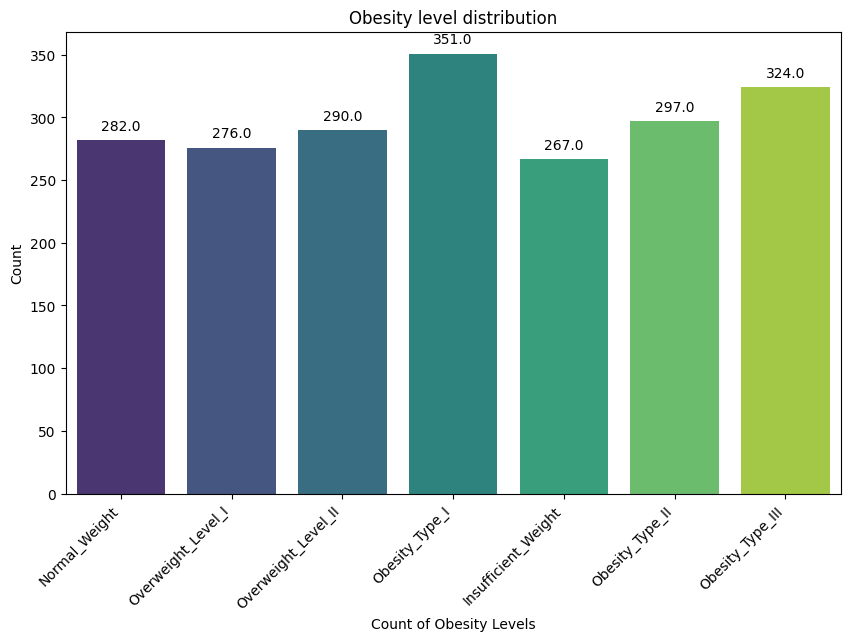

In [10]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='nobeyesdad', data=df, palette='viridis')
plt.xlabel('Count of Obesity Levels')
plt.ylabel('Count')
plt.title('Obesity level distribution')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display count on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [11]:
# Check cardinality of categorical features
num_features = tuple(df.select_dtypes(include=['float64']).columns)
cat_features = tuple(df.select_dtypes(include=['object']).columns)
for col in cat_features:
    print(f'{col} value counts')
    print(df[col].value_counts())
    print()



gender value counts
gender
Male      1052
Female    1035
Name: count, dtype: int64

family_history_with_overweight value counts
family_history_with_overweight
yes    1722
no      365
Name: count, dtype: int64

favc value counts
favc
yes    1844
no      243
Name: count, dtype: int64

caec value counts
caec
Sometimes     1761
Frequently     236
Always          53
no              37
Name: count, dtype: int64

smoke value counts
smoke
no     2043
yes      44
Name: count, dtype: int64

scc value counts
scc
no     1991
yes      96
Name: count, dtype: int64

calc value counts
calc
Sometimes     1380
no             636
Frequently      70
Always           1
Name: count, dtype: int64

mtrans value counts
mtrans
Public_Transportation    1558
Automobile                456
Walking                    55
Motorbike                  11
Bike                        7
Name: count, dtype: int64

nobeyesdad value counts
nobeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        

In [12]:
#One-Hot encoding categorical Variables
df['gender'] = (df.gender == 'Male').astype(int)
df.family_history_with_overweight = (df.family_history_with_overweight == 'yes').astype(int)
df.favc = (df.favc == 'yes').astype(int)
df.smoke = (df.smoke == 'yes').astype(int)
df.scc = (df.scc == 'yes').astype(int)
df = pd.concat([df, pd.get_dummies(df.mtrans).add_prefix('mtrans_')], axis=1)
df


,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,...,faf,tue,calc,mtrans,nobeyesdad,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,Sometimes,0,...,0.000000,1.000000,no,Public_Transportation,Normal_Weight,False,False,False,True,False
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,Sometimes,1,...,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight,False,False,False,True,False
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,Sometimes,0,...,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight,False,False,False,True,False
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,Sometimes,0,...,2.000000,0.000000,Frequently,Walking,Overweight_Level_I,False,False,False,False,True
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,Sometimes,0,...,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,Sometimes,0,...,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III,False,False,False,True,False
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,Sometimes,0,...,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III,False,False,False,True,False
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,Sometimes,0,...,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III,False,False,False,True,False
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,Sometimes,0,...,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III,False,False,False,True,False


In [13]:
#Label Encoding Ordinarl Variables
ord_encoders = {}
ord_vars = ('caec', 'calc', 'nobeyesdad')
ord_vals = [
    ('no', 'Sometimes', 'Frequently', 'Always'),
    ('no', 'Sometimes', 'Frequently', 'Always'),
    ('Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
     'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III')
]

# Create a dictionary to store the mapping of original to encoded values
encoding_maps = {}

for i, key in enumerate(ord_vars):
    print(key, ord_vals[i])
    ord_encoders[key] = OrdinalEncoder(categories=[ord_vals[i]])
    ord_encoders[key].fit(np.asarray(df[key]).reshape(-1, 1))
    col = 'ord_' + key
    df[col] = ord_encoders[key].transform(np.asarray(df[key]).reshape(-1, 1)).astype(int)

      # Store the mapping of original to encoded values
    encoding_maps[key] = {original: encoded for original, encoded in zip(ord_vals[i], range(len(ord_vals[i])))}

# Display the encoding maps
print("\nEncoded variables:")
for key, mapping in encoding_maps.items():
    print(f"\n{key}")
    for original, encoded in mapping.items():
        print(f"{original}: {encoded}")

#(Galloway, 2021)

caec ('no', 'Sometimes', 'Frequently', 'Always')
calc ('no', 'Sometimes', 'Frequently', 'Always')
nobeyesdad ('Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III')

Encoded variables:

caec
no: 0
Sometimes: 1
Frequently: 2
Always: 3

calc
no: 0
Sometimes: 1
Frequently: 2
Always: 3

nobeyesdad
Insufficient_Weight: 0
Normal_Weight: 1
Overweight_Level_I: 2
Overweight_Level_II: 3
Obesity_Type_I: 4
Obesity_Type_II: 5
Obesity_Type_III: 6


## **Feature Selection**

In [14]:
# Calculate the correlation matrix only for numerical features
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Extract the correlation of features with the target variable 'ord_nobeyesdad'
target_correlation = correlation_matrix['ord_nobeyesdad'].abs().sort_values(ascending=False)

# Display the correlation with the target variable
print(target_correlation)

ord_nobeyesdad                    1.000000
weight                            0.912453
family_history_with_overweight    0.503374
ord_caec                          0.342205
age                               0.279231
favc                              0.249927
fcvc                              0.228591
faf                               0.206001
scc                               0.197819
ord_calc                          0.155300
ch2o                              0.134170
height                            0.124863
tue                               0.115323
gender                            0.031920
ncp                               0.011034
smoke                             0.001984
Name: ord_nobeyesdad, dtype: float64


In [15]:
# Remove the 'Weight' feature due to highest level of correlation and fact that dataset uses BMI to classify obesity
df = df.drop(columns=['weight'])

In [16]:
#Data Integration after encoding
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df

,gender,age,height,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,...,mtrans,nobeyesdad,mtrans_automobile,mtrans_bike,mtrans_motorbike,mtrans_public_transportation,mtrans_walking,ord_caec,ord_calc,ord_nobeyesdad
0,0,21.000000,1.620000,1,0,2.0,3.0,Sometimes,0,2.000000,...,Public_Transportation,Normal_Weight,False,False,False,True,False,1,0,1
1,0,21.000000,1.520000,1,0,3.0,3.0,Sometimes,1,3.000000,...,Public_Transportation,Normal_Weight,False,False,False,True,False,1,1,1
2,1,23.000000,1.800000,1,0,2.0,3.0,Sometimes,0,2.000000,...,Public_Transportation,Normal_Weight,False,False,False,True,False,1,2,1
3,1,27.000000,1.800000,0,0,3.0,3.0,Sometimes,0,2.000000,...,Walking,Overweight_Level_I,False,False,False,False,True,1,2,2
4,1,22.000000,1.780000,0,0,2.0,1.0,Sometimes,0,2.000000,...,Public_Transportation,Overweight_Level_II,False,False,False,True,False,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,1,1,3.0,3.0,Sometimes,0,1.728139,...,Public_Transportation,Obesity_Type_III,False,False,False,True,False,1,1,6
2107,0,21.982942,1.748584,1,1,3.0,3.0,Sometimes,0,2.005130,...,Public_Transportation,Obesity_Type_III,False,False,False,True,False,1,1,6
2108,0,22.524036,1.752206,1,1,3.0,3.0,Sometimes,0,2.054193,...,Public_Transportation,Obesity_Type_III,False,False,False,True,False,1,1,6
2109,0,24.361936,1.739450,1,1,3.0,3.0,Sometimes,0,2.852339,...,Public_Transportation,Obesity_Type_III,False,False,False,True,False,1,1,6


In [17]:
# Calculate the correlation matrix only for numerical features
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Extract the correlation of features with the target variable 'ord_nobeyesdad'
target_correlation = correlation_matrix['ord_nobeyesdad'].abs().sort_values(ascending=False)

# Display the correlation with the target variable
print(target_correlation)

ord_nobeyesdad                    1.000000
family_history_with_overweight    0.503374
ord_caec                          0.342205
age                               0.279231
favc                              0.249927
fcvc                              0.228591
faf                               0.206001
scc                               0.197819
ord_calc                          0.155300
ch2o                              0.134170
height                            0.124863
tue                               0.115323
gender                            0.031920
ncp                               0.011034
smoke                             0.001984
Name: ord_nobeyesdad, dtype: float64


## **Statistical Significance**

In [27]:
# ANOVA for categorical predictors
categorical_predictors = ['gender', 'family_history_with_overweight', 'favc', 'smoke', 'scc', 'mtrans_automobile', 'mtrans_bike', 'mtrans_motorbike', 'mtrans_public_transportation', 'mtrans_walking']
anova_results = {}

for predictor in categorical_predictors:
    groups = df.groupby(predictor)['ord_nobeyesdad'].apply(list)
    f_stat, p_value = f_oneway(*groups)
    anova_results[predictor] = p_value

print("ANOVA Results for Categorical Predictors:")
for predictor, p_value in anova_results.items():
    print(f"{predictor}: p-value = {p_value:.4f}")

# Linear Regression for continuous predictors
continuous_predictors = ['age', 'height', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue', 'ord_caec', 'ord_calc']
linear_regression_results = {}

for predictor in continuous_predictors:
    model = ols(f'ord_nobeyesdad ~ {predictor}', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table['PR(>F)'][predictor]
    linear_regression_results[predictor] = p_value

print("\nLinear Regression Results for Continuous Predictors:")
for predictor, p_value in linear_regression_results.items():
    print(f"{predictor}: p-value = {p_value:.4f}")


ANOVA Results for Categorical Predictors:
gender: p-value = 0.1449
family_history_with_overweight: p-value = 0.0000
favc: p-value = 0.0000
smoke: p-value = 0.9278
scc: p-value = 0.0000
mtrans_automobile: p-value = 0.1885
mtrans_bike: p-value = 0.0888
mtrans_motorbike: p-value = 0.0812
mtrans_public_transportation: p-value = 0.0000
mtrans_walking: p-value = 0.0000

Linear Regression Results for Continuous Predictors:
age: p-value = 0.0000
height: p-value = 0.0000
fcvc: p-value = 0.0000
ncp: p-value = 0.6144
ch2o: p-value = 0.0000
faf: p-value = 0.0000
tue: p-value = 0.0000
ord_caec: p-value = 0.0000
ord_calc: p-value = 0.0000


## Outlier Detection - decided to keep outliers due to 23% directly collected data and 77% being generated synthetically using the Weka tool and the SMOTE filter

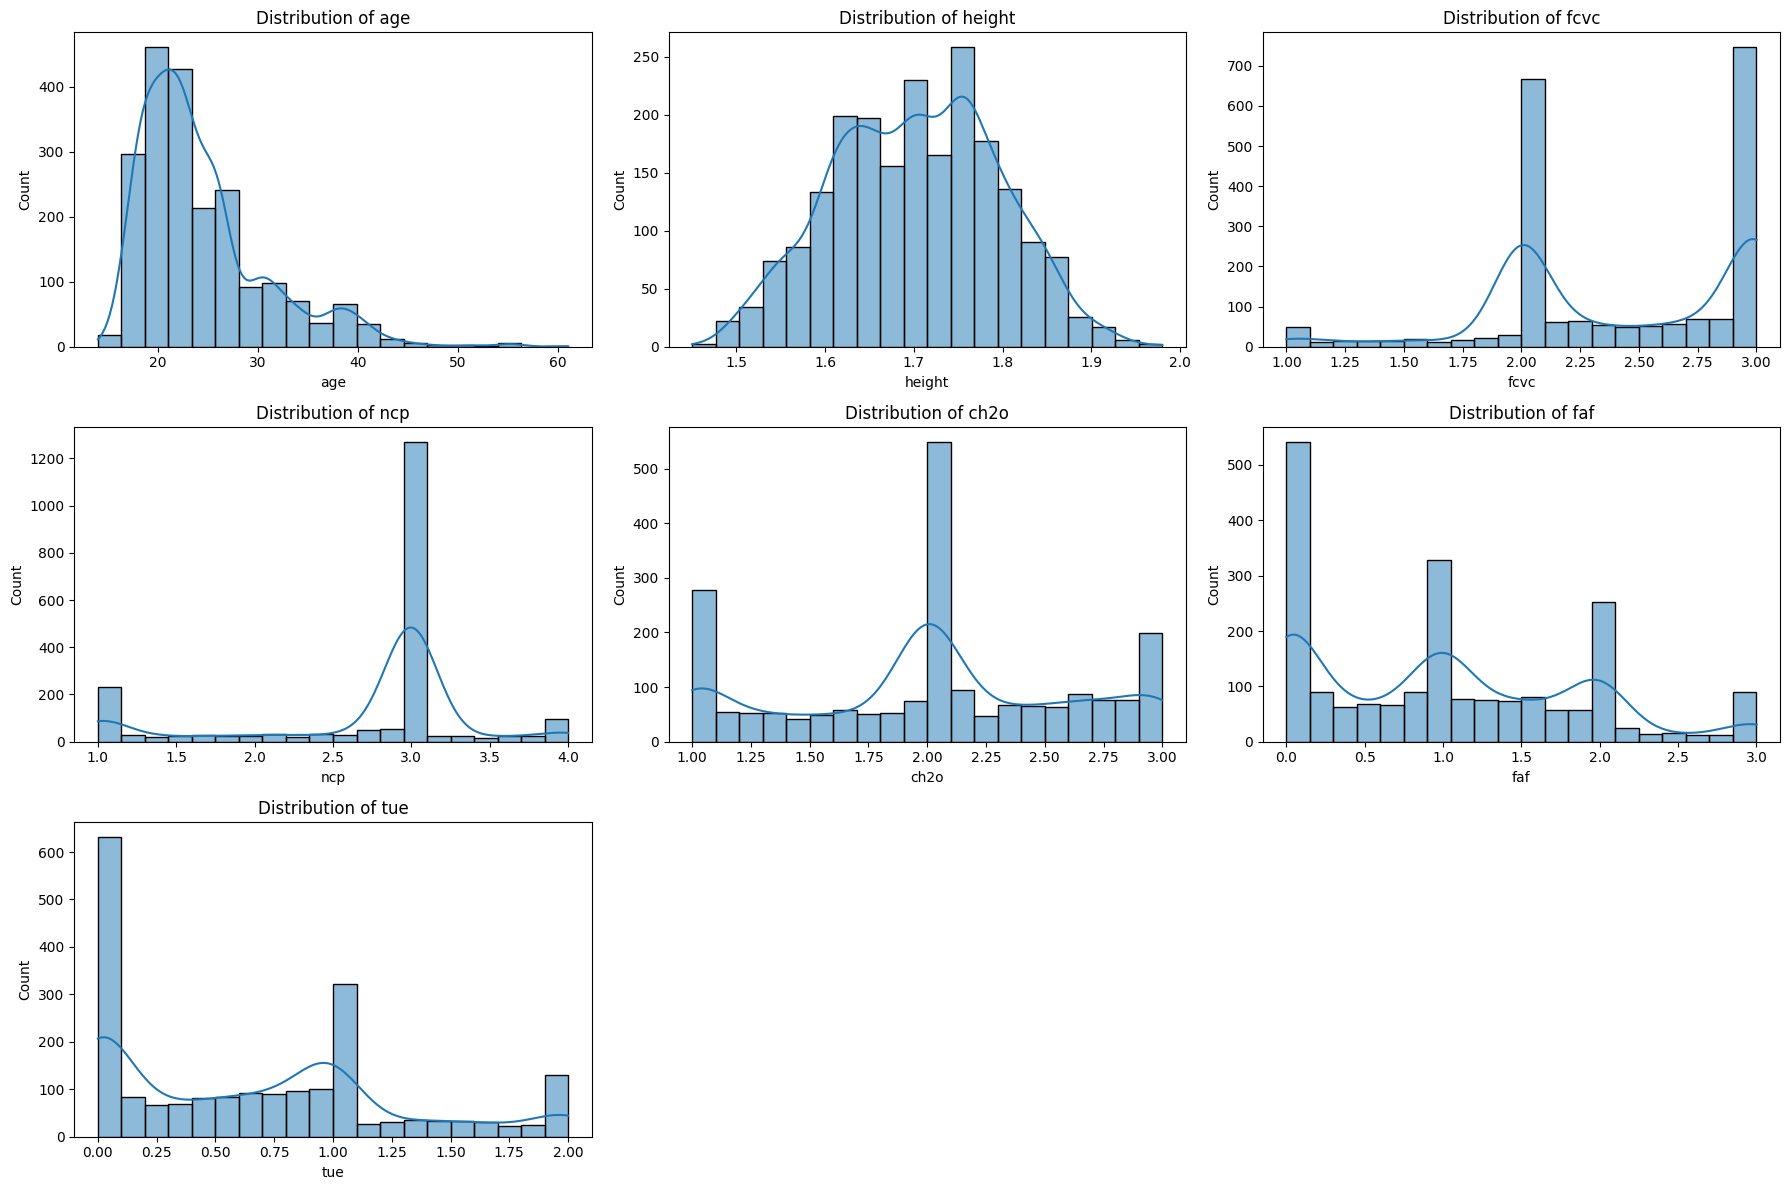

In [28]:
# Visualize distributions of numerical features
numerical_columns = ['age', 'height', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue']

plt.figure(figsize=(18, 12))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


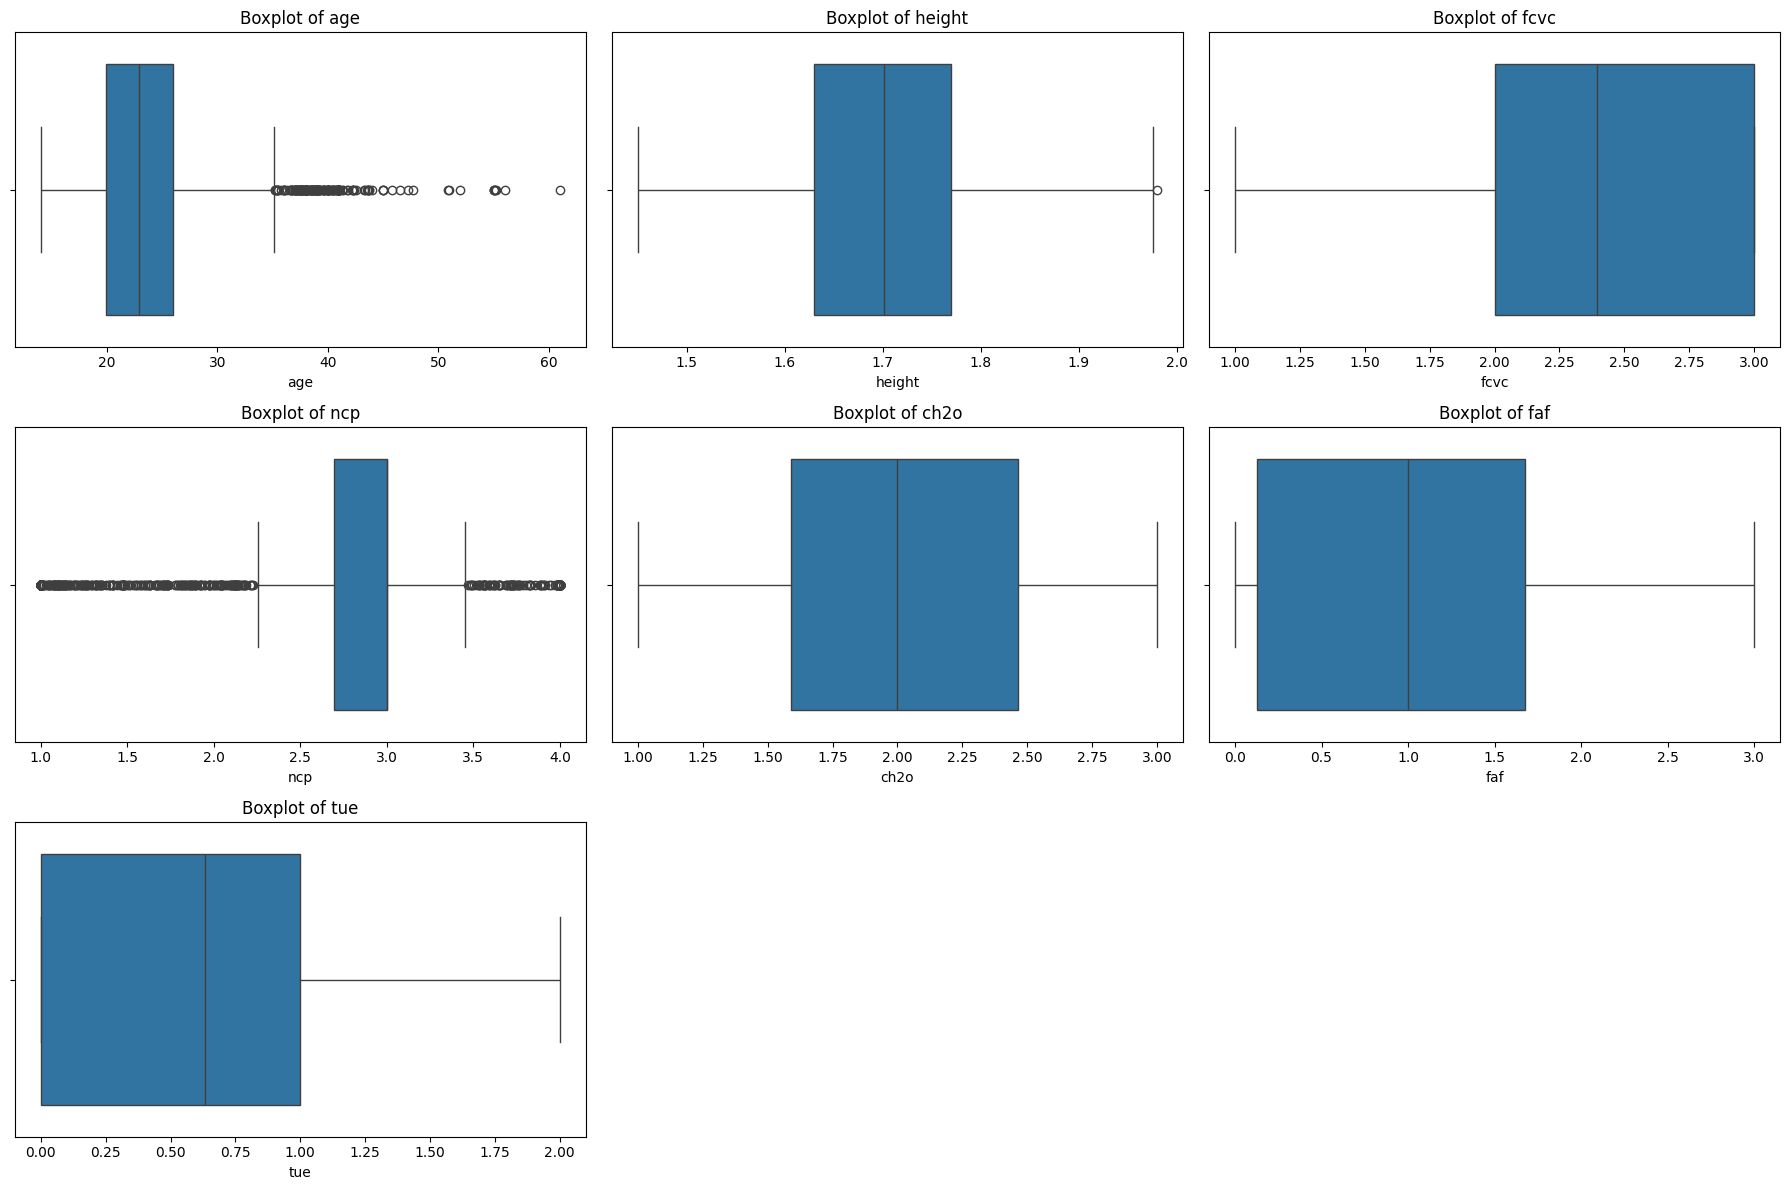

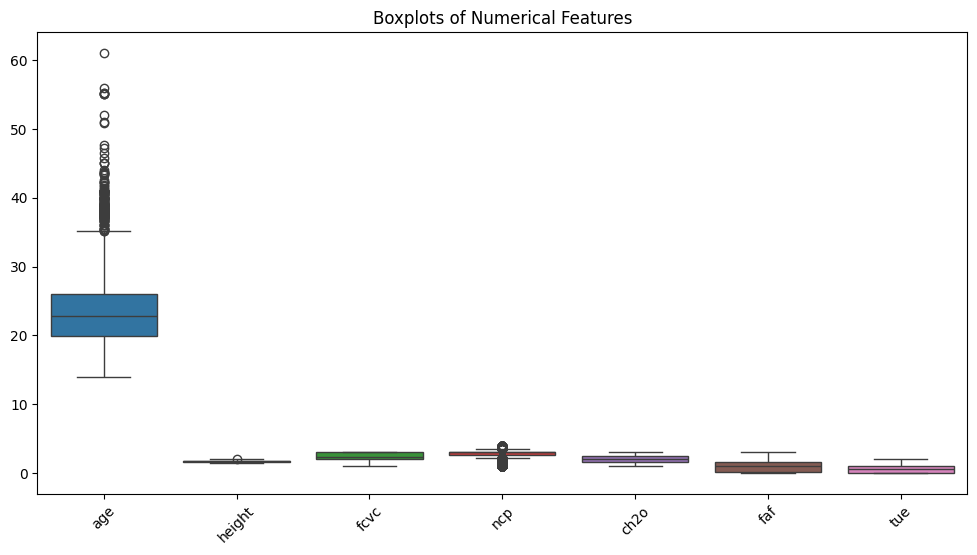

In [29]:
#Separate box plot for each numerical column vs single boxplot for all numerical columns
plt.figure(figsize=(18, 12))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()


In [30]:
#Z-score
z_scores = np.abs(df[numerical_columns].apply(zscore))

threshold = 3
outliers_z = (z_scores > threshold)

num_outliers_z = outliers_z.sum().sum()
print(f"Total number of outliers (Z-score method): {num_outliers_z}")



Total number of outliers (Z-score method): 23


In [31]:
#IQR per feature
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    return outliers

outliers = detect_outliers(df, numerical_columns)

outlier_counts = {col: len(outliers[col]) for col in numerical_columns}
print("Number of outliers in each feature:\n", outlier_counts)


Number of outliers in each feature:
 {'age': 167, 'height': 1, 'fcvc': 0, 'ncp': 577, 'ch2o': 0, 'faf': 0, 'tue': 0}


In [32]:
#IQR Outliners of all features
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) |
            (df[numerical_columns] > (Q3 + 1.5 * IQR)))

df_outliers = df[outliers.any(axis=1)]
print(f"Total number of outliers: {len(df_outliers)}\n")

Total number of outliers: 698



## Code around binning - decided to not persue

<ipython-input-33-c28ee005bbea>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_bin_counts.index, y=age_bin_counts.values, palette='viridis')


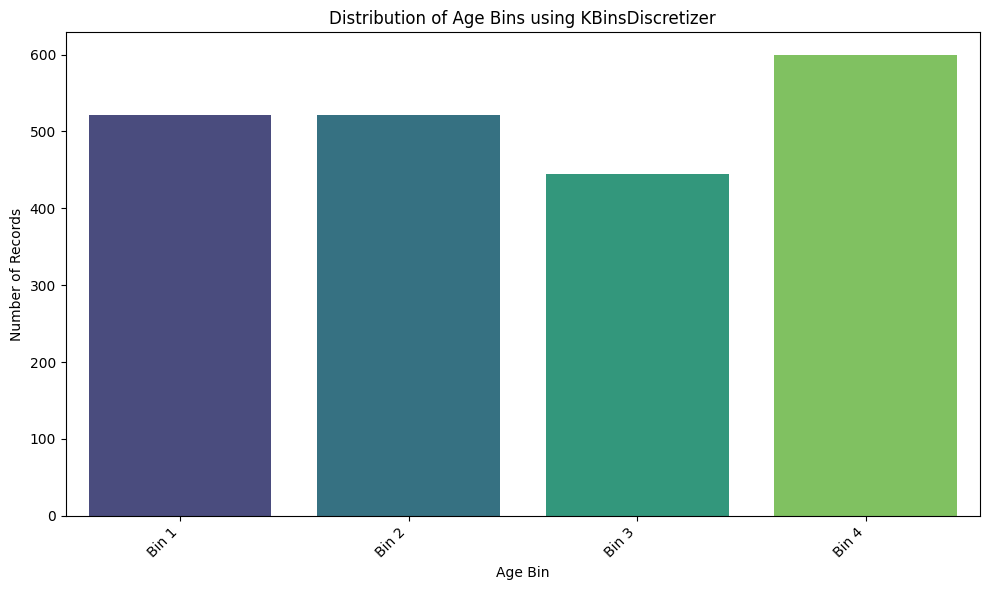

                  min        max
age_binned                      
0.0         14.000000  19.911246
1.0         19.920629  22.846357
2.0         22.847618  25.999942
3.0         26.000000  61.000000


,count
age_binned,
0.0,522
1.0,521
2.0,445
3.0,599


In [33]:
from sklearn.preprocessing import KBinsDiscretizer

k_bins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df['age_binned'] = k_bins.fit_transform(df[['age']])

age_bin_counts = df['age_binned'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_bin_counts.index, y=age_bin_counts.values, palette='viridis')


plt.xlabel('Age Bin')
plt.ylabel('Number of Records')
plt.title('Distribution of Age Bins using KBinsDiscretizer')
plt.xticks(ticks=range(4), labels=['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

age_bin_ranges = df.groupby('age_binned')['age'].describe()[['min', 'max']]
print(age_bin_ranges)

age_bin_counts


<ipython-input-34-85c2324d9f61>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_quartile_counts.index, y=age_quartile_counts.values, palette='viridis')


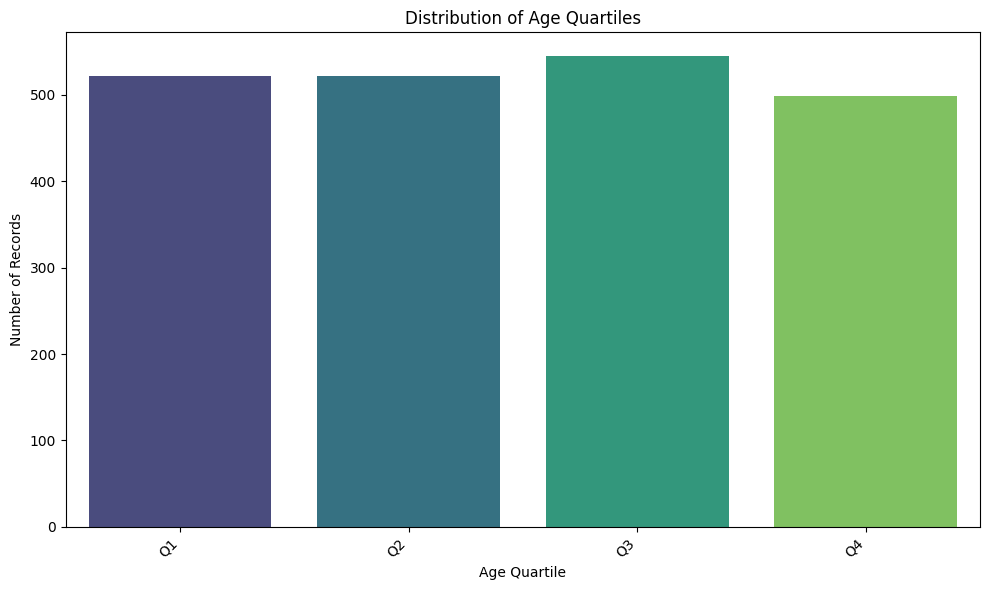

                    min        max
age_quartile                      
Q1            14.000000  19.911246
Q2            19.920629  22.847618
Q3            22.851721  26.000000
Q4            26.004294  61.000000


<ipython-input-34-85c2324d9f61>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_quartile_ranges = df.groupby('age_quartile')['age'].describe()[['min', 'max']]


,count
age_quartile,
Q1,522
Q2,522
Q3,545
Q4,498


In [34]:
df['age_quartile'] = pd.qcut(df['age'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

age_quartile_counts = df['age_quartile'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_quartile_counts.index, y=age_quartile_counts.values, palette='viridis')

plt.xlabel('Age Quartile')
plt.ylabel('Number of Records')
plt.title('Distribution of Age Quartiles')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

age_quartile_ranges = df.groupby('age_quartile')['age'].describe()[['min', 'max']]
age_quartile_ranges
print(age_quartile_ranges)

age_quartile_counts

#(Mistral AI, 2025)

## **Feature Scaling: Min-Max Scalar**

In [35]:
# Min-Max Scaling
scaler = MinMaxScaler()
x_cols = ['gender', 'age', 'height','family_history_with_overweight',
          'favc', 'fcvc', 'ncp', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'ord_caec',
          'ord_calc', 'mtrans_automobile', 'mtrans_bike', 'mtrans_motorbike',
          'mtrans_public_transportation', 'mtrans_walking']
df[x_cols] = scaler.fit_transform(df[x_cols])
df[x_cols].head()

#(Scikit-learn, 2025)

,gender,age,height,family_history_with_overweight,favc,fcvc,ncp,smoke,ch2o,scc,faf,tue,ord_caec,ord_calc,mtrans_automobile,mtrans_bike,mtrans_motorbike,mtrans_public_transportation,mtrans_walking
0,0.0,0.148936,0.320755,1.0,0.0,0.5,0.666667,0.0,0.5,0.0,0.000000,0.5,0.333333,0.000000,0.0,0.0,0.0,1.0,0.0
1,0.0,0.148936,0.132075,1.0,0.0,1.0,0.666667,1.0,1.0,1.0,1.000000,0.0,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0
2,1.0,0.191489,0.660377,1.0,0.0,0.5,0.666667,0.0,0.5,0.0,0.666667,0.5,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0
3,1.0,0.276596,0.660377,0.0,0.0,1.0,0.666667,0.0,0.5,0.0,0.666667,0.0,0.333333,0.666667,0.0,0.0,0.0,0.0,1.0
4,1.0,0.170213,0.622642,0.0,0.0,0.5,0.000000,0.0,0.5,0.0,0.000000,0.0,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0


# **Train-test split with stratification [stratify]- 70% testing and 30% training**

In [36]:
X = df[x_cols]
y = df['ord_nobeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


print(f'X-train {X_train.shape}')
print(f'X-test {X_test.shape}')
print(f'y-train {y_train.shape}')
print(f'y-test {y_test.shape}')

#(Scikit-learn, 2025)

X-train (1460, 19)
X-test (627, 19)
y-train (1460,)
y-test (627,)


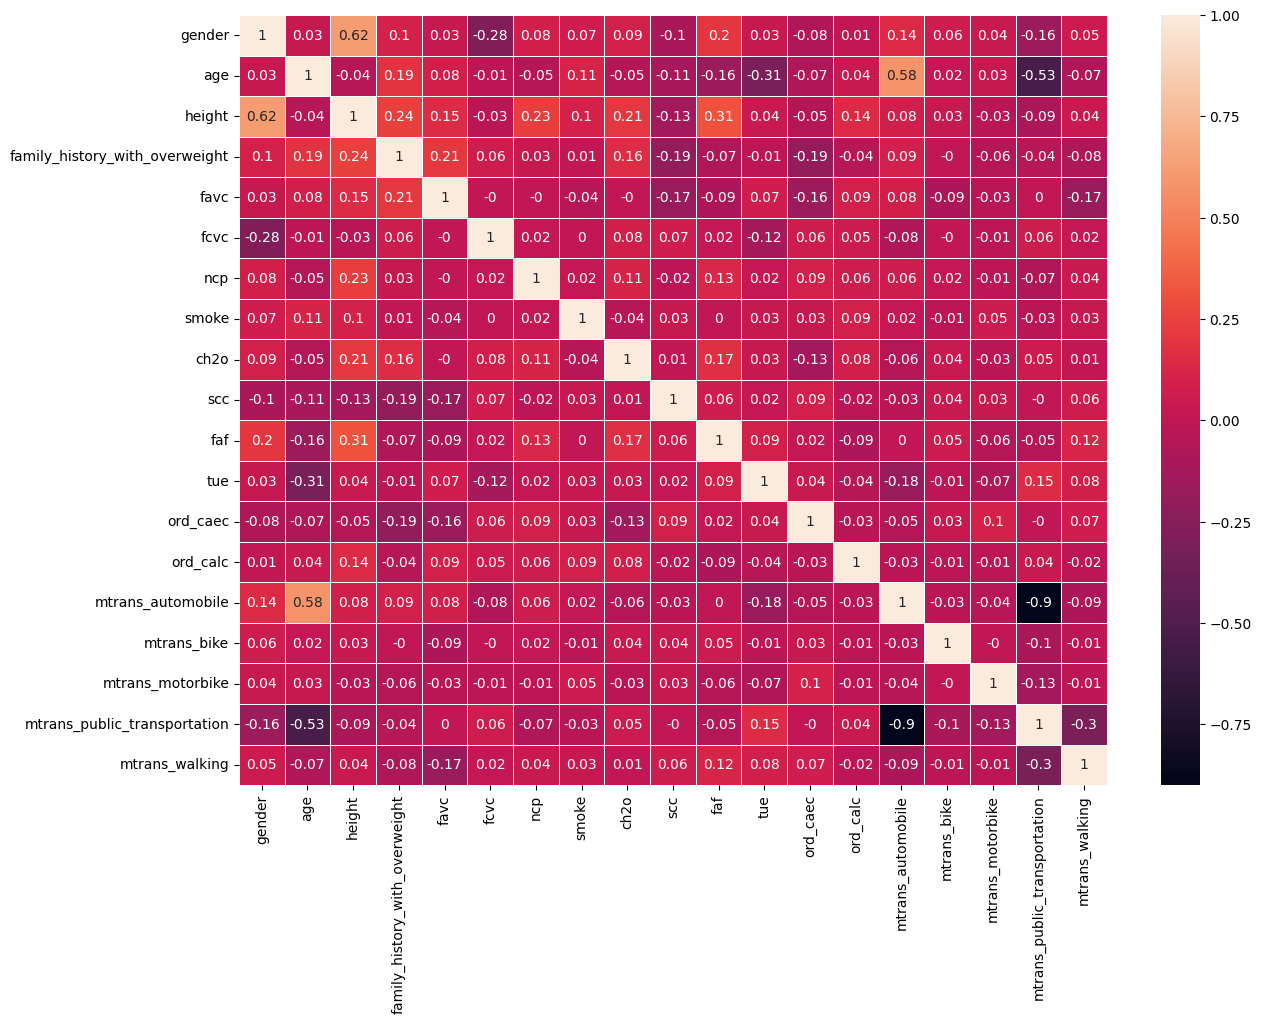

In [37]:
plt.figure(figsize=(14,10))
_=sns.heatmap(X_train.corr().round(2), annot=True, linewidths=.5)
plt.show()

#(Shen, 2022)

# **Model Evaluation - Applying Algorithims**

In [38]:
# Define a function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'auc_roc': auc_roc
    }

## SVM


In [ ]:
#SVM Model - hyper parameter tuning using grid search
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}
svm = SVC(decision_function_shape='ovr', probability=True, random_state=1)
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
best_params = grid_search_svm.best_params_ # Assign the best parameters to the variable
print("Best Hyperparameters:", best_params) # print best hyperparameters

best_svm = SVC(**grid_search_svm.best_params_, probability=True, random_state=1)
best_svm.fit(X_train, y_train)
svm_results = evaluate_model(best_svm, X_test, y_test)
svm_results

## XGBoost

In [ ]:
#XGBoost model - hyper parameter tuning using grid search
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=1)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

In [ ]:
best_params = grid_search_xgb.best_params_ # Assign the best parameters to the variable
print("Best Hyperparameters:", best_params) # print best hyperparameters

best_xgb_model = XGBClassifier(**grid_search_xgb.best_params_, eval_metric='logloss', random_state=1)
best_xgb_model.fit(X_train, y_train)
xgb_results = evaluate_model(best_xgb_model, X_test, y_test)
xgb_results

## Random Forest




In [ ]:
# Random Forest Model
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestClassifier(random_state=1)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

In [ ]:
best_params = grid_search_rf.best_params_ # Assign the best parameters to the variable
print("Best Hyperparameters:", best_params) # print best hyperparameters

best_rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=1)
best_rf_model.fit(X_train, y_train)
rf_results = evaluate_model(best_rf_model, X_test, y_test)
rf_results

## Logistic Regression

In [ ]:
# Logistic Regression Model
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [500, 1000, 2000]
}
lr_model = LogisticRegression(random_state=1)
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

In [ ]:
best_params = grid_search_lr.best_params_ # Assign the best parameters to the variable
print("Best Hyperparameters:", best_params) # print best hyperparameters

best_lr_model = LogisticRegression(**grid_search_lr.best_params_, random_state=1)
best_lr_model.fit(X_train, y_train)
lr_results = evaluate_model(best_lr_model, X_test, y_test)
lr_results

#(Musa, Basaky and Osaghae, 2022; Mistral AI, 2025)

## Ensemble Modeling

In [ ]:
# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', best_svm),
    ('xgb', best_xgb_model),
    ('rf', best_rf_model),
    ('lr', best_lr_model)
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate the Voting Classifier
voting_results = evaluate_model(voting_clf, X_test, y_test)

# Print the evaluation results
print("Voting Classifier Results:")
print(voting_results)

# Save the Voting Classifier model
joblib.dump(voting_clf, 'voting_classifier_model.pkl')


## **Model Results**


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

# Compile results including the Voting Classifier
models = {
    'SVM': best_svm,
    'XGBoost': best_xgb_model,
    'Random Forest': best_rf_model,
    'Logistic Regression': best_lr_model,
    'Voting Classifier': voting_clf
}

# Plot confusion matrices for all models
for model_name, model in models.items():
    print(f"Plotting Confusion Matrix for {model_name}...")
    plot_confusion_matrix(model, X_test, y_test, f'Confusion Matrix for {model_name}')


In [ ]:

# Compile results including the Voting Classifier
models = {
    'SVM': best_svm,
    'XGBoost': best_xgb_model,
    'Random Forest': best_rf_model,
    'Logistic Regression': best_lr_model,
    'Voting Classifier': voting_clf
}
metrics_summary = pd.DataFrame({model_name: evaluate_model(model, X_test, y_test) for model_name, model in models.items()}).T

# Print the summary
print(metrics_summary)



In [ ]:
# Plotting the metrics
metrics = ['precision', 'recall', 'f1_score', 'accuracy', 'auc_roc']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_summary.index, metrics_summary[metric], color=colors)
    for i, v in enumerate(metrics_summary[metric]):
        plt.text(i, v / 2, f"{v*100:.2f}%", ha='center', va='center', color='white')
    plt.xlabel('Classification Models')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} of Different Classification Models')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Save the Voting Classifier model
joblib.dump(voting_clf, 'voting_classifier_model.pkl')

#(Mistral AI, 2025)

In [ ]:
# Format to percentage with 2 decimal places
metrics_summary = metrics_summary.applymap(lambda x: f'{x:.2%}')

# Print the summary
print(metrics_summary)
